# Импорты

In [ ]:
# массивы, рандом
import pandas as pd
import numpy as np

# файлы
from os.path import join as pjoin
import os
import json

# модельки
import segmentation_models_pytorch as smp

# torch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

# аугментация
import albumentations as album

# отображение
# from tqdm import tqdm
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import torchvision
import torchinfo
from torch.utils.tensorboard import SummaryWriter
from board import uniqufy_path, create_image_plot

# метрики
from torchmetrics.classification import BinaryJaccardIndex
from sklearn.metrics import confusion_matrix

# оптимизаторы, изменение lr
from torch.optim.lr_scheduler import ReduceLROnPlateau

# лос
from segmentation_models_pytorch.losses import LovaszLoss, DiceLoss


# Константы

In [ ]:
DATA_DIR = './../../roads_dataset_cropped/tiff/'
DATA_CLASSES = "./../../roads_dataset_cropped/label_class_dict.csv"

MEAN_IMAGE_TRANSFORM = [0.4363, 0.4328, 0.3291]
MEAN_IMAGE_STD = [0.2129, 0.2075, 0.2038]
SIZE_IMAGE = 256
BATCH_SIZE = 32
NUM_WORKERS = 15
EPOCHS = 15

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Параметры

In [ ]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_labels')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'val_labels')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'test_labels')

class_dict = pd.read_csv(DATA_CLASSES)
CLASSES = class_dict['name'].tolist()
CLASSES_RGB = class_dict[['r','g','b']].values.tolist()

print('Классы: ', CLASSES)
print('Классы RGB значений: ', CLASSES_RGB)

with open('parametrs.json', 'r', encoding='utf-8') as f:
    PARAMETERS = json.load(f)

# Функции

In [ ]:
# ОТОБРАЖЕНИЕ
def print_image(**images):
    n_images = len(images)
    plt.figure(figsize=(16, 4))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(name.replace('_', ' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

# ПРЕОБРАЗОВАНИЯ
def one_hot_encode(label, label_values):
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis=-1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)
    return semantic_map


def reverse_one_hot(image):
    x = np.argmax(image, axis=-1)
    return x

def colour_code_segmentation(image, label_values):
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]
    return x

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def prepare_to_network():
    return album.Lambda(image=to_tensor, mask=to_tensor)

def transform_train():
    train_transform = album.Compose(
        [
            album.OneOf(
                [
                    album.HorizontalFlip(p=1),
                    album.VerticalFlip(p=1),
                    album.RandomRotate90(p=1),
                ],
                p=0.75,
            ),
            album.Normalize(mean=MEAN_IMAGE_TRANSFORM,
                            std=MEAN_IMAGE_STD, always_apply=True)
        ]
    )
    return train_transform


def transform_test():
    test_transform = album.Compose([
        album.Normalize(mean=MEAN_IMAGE_TRANSFORM,
                        std=MEAN_IMAGE_STD, always_apply=True)
    ])
    return test_transform

def calculate_dice(labels, output):
    with torch.no_grad():
        y_true = reverse_one_hot(
            labels[0].cpu().numpy().transpose(2, 1, 0)).flatten()
        y_pred = reverse_one_hot(
            output[0].cpu().numpy().transpose(2, 1, 0)).flatten()

        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        metric_values = (2*tp)/(2*tp+tn+tp)
        return metric_values


def train_step(model, criterion, optimizer, dataloader, epoch, epochs):
    model.train()
    running_loss = 0.

    for i, (images, labels) in enumerate(dataloader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        output = model(images)
        loss = criterion(output, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss

    with torch.no_grad():
        train_loss = running_loss / len(dataloader)
    return train_loss.item()


def valid_step(model, criterion, dataloader, epoch, BOARD):
    model.eval()
    running_loss = 0.

    dice = 0
    iou = BinaryJaccardIndex(num_classes=2)
    iou.to(DEVICE)

    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader):
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            output = model(images)

            iou(output, labels)
            dice += calculate_dice(labels, output)

            loss = criterion(output, labels)
            running_loss += loss

            BOARD.add_figure('valid_sample_' + str(i), create_image_plot(
                origin=images[0].cpu().numpy().transpose(2, 1, 0),
                true=colour_code_segmentation(reverse_one_hot(
                    labels[0].cpu().numpy().transpose(2, 1, 0)), CLASSES_RGB),
                pred=colour_code_segmentation(reverse_one_hot(
                    output[0].cpu().numpy().transpose(2, 1, 0)), CLASSES_RGB)),
                epoch)
        
        metric_dice =  dice / len(dataloader)
        valid_loss = running_loss / len(dataloader)
        return valid_loss.item(), iou.compute().item(), metric_dice


# Классы

In [ ]:
class RoadsDataset(Dataset):
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            class_rgb_values=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir))]
        self.mask_paths = [os.path.join(masks_dir, image_id) for image_id in sorted(os.listdir(masks_dir))]

        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)
        
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')
        
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        return image, mask
        
    def __len__(self):
        return len(self.image_paths)

# Загрузка валидации и теста

In [ ]:
train_dataset = RoadsDataset(x_train_dir, y_train_dir,
                             class_rgb_values=CLASSES_RGB, augmentation=transform_train(), preprocessing=prepare_to_network())
valid_dataset = RoadsDataset(x_valid_dir, y_valid_dir,
                             class_rgb_values=CLASSES_RGB, augmentation=transform_test(), preprocessing=prepare_to_network())
test_dataset = RoadsDataset(x_test_dir, y_test_dir,
                            class_rgb_values=CLASSES_RGB, augmentation=transform_test(), preprocessing=prepare_to_network())
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
)
valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=4,
    num_workers=4,
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=4,
    num_workers=4,
)


# ПОДГОТОВКА ОБУЧЕНИЕ

In [ ]:
TBpath = uniqufy_path('res/best')
BOARD = SummaryWriter(TBpath)

# МОДЕЛЬ
model = smp.Unet(
    encoder_name='resnet50',
    encoder_weights='imagenet',
    classes=len(CLASSES),
    activation=nn.ReLU)
model = model.to(DEVICE)

# ПАРАМЕТРЫ ДЛЯ ОБУЧЕНИЯ
criterion = DiceLoss(mode='binary')
optimizer = torch.optim.Adam(
    params=model.parameters(), lr=0.001) # weight_decay=0.000001
scheduler = ReduceLROnPlateau(optimizer, 'min',
                                patience=2, threshold=1e-3,
                                cooldown=1, factor=0.1)

# # ОБУЧЕНИЕ

In [ ]:
# ПЕРЕМЕННЫЕ ДЛЯ ГРАФИКОВ
len_steps = len(train_dataloader)

pbar = tqdm(range(EPOCHS))
for epoch in range(EPOCHS):
    for i, param_group in enumerate(optimizer.param_groups):
        BOARD.add_scalar('learning rate', float(param_group['lr']), epoch)

    train_loss = train_step(
        model, criterion, optimizer, train_dataloader, epoch, EPOCHS)
    valid_loss, metric_iou, dice = valid_step(
        model, criterion, valid_dataloader, epoch, BOARD)

    scheduler.step(valid_loss)

    BOARD.add_scalar('loss_valid', valid_loss, epoch)
    BOARD.add_scalar('loss_train', train_loss, epoch)

    BOARD.add_scalar('metric_iou', metric_iou, epoch)
    BOARD.add_scalar('metric_dice', (1 - valid_loss), epoch)
    
    torch.save(model.state_dict(), f'./model_{i}.pth')
    
    pbar.update()
    pbar.set_description(
        f'iou: {metric_iou:.2f} dice: {dice:.2f}  | train/valid loss: {train_loss:.4f}/{valid_loss:.4f}')


# TEST

In [ ]:
iou = BinaryJaccardIndex(num_classes=2)
iou.to(DEVICE)
dice = 0

running_loss = 0

with torch.no_grad():
    for i, (images, labels) in enumerate(test_dataloader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        output = model(images)

        dice += calculate_dice(labels, output)
        iou.update(output, labels)

        BOARD.add_figure('test_sample', create_image_plot(
            origin=images[0].cpu().numpy().transpose(2, 1, 0),
            true=colour_code_segmentation(reverse_one_hot(
                labels[0].cpu().numpy().transpose(2, 1, 0)), CLASSES_RGB),
            pred=colour_code_segmentation(reverse_one_hot(
                output[0].cpu().numpy().transpose(2, 1, 0)), CLASSES_RGB)),
            i)

        pbar.update()

    metric_dice =  dice / len(test_dataloader)
    print(metric_dice)
    print(f'dice: {metric_dice}')
    print(f'iou: {iou.compute().item()}')

BOARD.close()


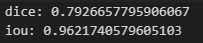